
## captions are strictly mandatory: no captions no points. The discussion of what you do is the ultimate deliverable of each task

Captions need to describe: what is plotted and what is interesting about it


PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code.






## respect coding standards
*The [following PEP8 rules](https://docs.google.com/document/d/1-XnKK4xRBA5FXOBa4p0Z4in7qfVyk4CutjSMEX-jpTQ/edit?usp=sharing) are now required*

Points will be taken off if they are violated

## problem statement

** An interesting and popular urban science question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

# data acquisition

## download, move data to $PUIDATA, and read data in 
make sure you limit the PLUTO dataset to Manhattan, The entire NYC PLUTO dataset is huge!

...download...

In [1]:
import os, sys, json, requests
import pandas as pd
import numpy as np
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon
import shapely, fiona
import geopandas as gp
import matplotlib.pyplot as plt
import urllib
from pandas.tools.plotting import scatter_matrix
import pylab as pl
import statsmodels.formula.api as smf
import matplotlib.gridspec as gridspec
import statsmodels

In [3]:
os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/ty1045/PUIdata


In [3]:
!curl 'https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD' > Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4329k    0 4329k    0     0  2756k      0 --:--:--  0:00:01 --:--:-- 2755k


In [4]:
!mv Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv PUIdata

In [5]:
!wget 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip'

--2018-11-24 17:08:46--  https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip
Resolving www1.nyc.gov (www1.nyc.gov)... 104.108.104.236, 2600:1408:10:180::1500, 2600:1408:10:186::1500
Connecting to www1.nyc.gov (www1.nyc.gov)|104.108.104.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9857321 (9.4M) [application/zip]
Saving to: ‘mn_mappluto_16v2.zip’

mn_mappluto_16v2.zi 100%[===================>]   9.40M  --.-KB/s    in 0.05s   

2018-11-24 17:08:46 (184 MB/s) - ‘mn_mappluto_16v2.zip’ saved [9857321/9857321]



In [6]:
!unzip mn_mappluto_16v2.zip

Archive:  mn_mappluto_16v2.zip
  inflating: PLUTODD16v2.pdf         
  inflating: MN_Dcp_Mappinglot.dbf   
  inflating: MN_Dcp_Mappinglot.prj   
  inflating: MN_Dcp_Mappinglot.sbn   
  inflating: MN_Dcp_Mappinglot.sbx   
  inflating: MN_Dcp_Mappinglot.shp   
  inflating: MN_Dcp_Mappinglot.shp.xml  
  inflating: MN_Dcp_Mappinglot.shx   
  inflating: mn_pluto.dbf            
  inflating: mn_pluto.dbf.xml        
  inflating: MNMapPLUTO.BBL.atx      
  inflating: MNMapPLUTO.CD.atx       
  inflating: MNMapPLUTO.dbf          
  inflating: MNMapPLUTO.LandUse.atx  
  inflating: MNMapPLUTO.prj          
  inflating: MNMapPLUTO.sbn          
  inflating: MNMapPLUTO.sbx          
  inflating: MNMapPLUTO.shp          
  inflating: MNMapPLUTO.shp.xml      
  inflating: MNMapPLUTO.shx          
  inflating: MNMapPLUTO.ZoneDist1.atx  


In [30]:
!mv MNMapPLUTO

In [4]:
# load the buildinmg size as a geoDF and the local law 84 as a dtaframe
nrg = pd.read_csv(os.getenv("PUIDATA") + 
                  "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")

bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/MNMapPLUTO.shp")

In [5]:
nrg.head(3)

,Record Number,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Postcode,DOF Benchmarking Submission Status,...,DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,82730.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
bsize.head(3)

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,geometry
0,MN,1,201,101,1,1000,02,1,10004,E007,...,10101,None,0.000000e+00,None,1,16V2,0,6306.265838,1.148541e+06,"POLYGON ((973154.7117999941 194614.3315999955,..."
1,MN,9,14,101,9,1013,02,1,10004,L015,...,10101,None,1.000090e+09,12/26/1985,1,16V2,0,686.230174,2.373306e+04,"POLYGON ((980492.3622000068 195423.9451999962,..."
2,MN,15,7501,101,13,2005,02,1,10004,E010,...,10101,None,1.000150e+09,12/29/1998,1,16V2,7,1098.925676,6.753824e+04,"POLYGON ((979999.0820000023 196493.2800000012,..."


## exploring the data a bit

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


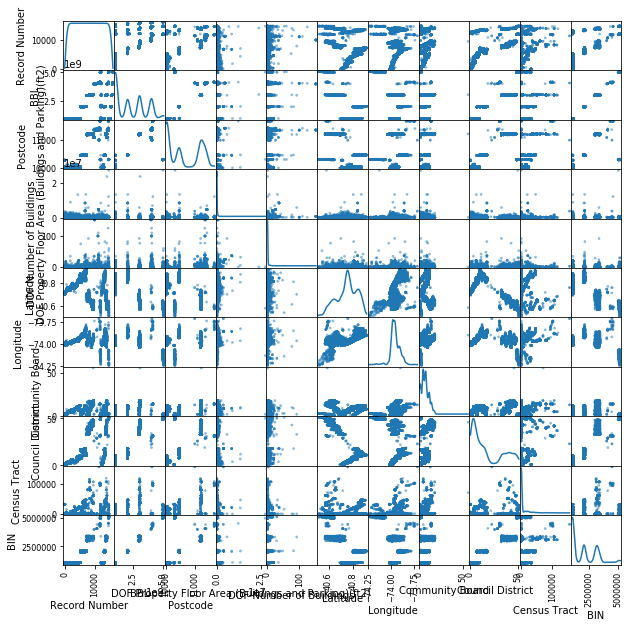

In [11]:
sfig = scatter_matrix(nrg, s=30, figsize=(10, 10), diagonal='kde')

### Figure 1. Scatter matrix of all numerical values in Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv. We can clearly observe some linear correlations between some variables. However, as there are too many variables, we can just focus on the ones that we're interested in.

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

## data cleaning and aggregation 
### checking the content of the datasets


clean up columns I am not using: for my solution, I will keep  BBL, 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)' from the energy dataframe, and BBL , UnitsTotal, UnitsRes, 'YearBuilt', and 'geometry' from the PLUTO geodaraframe

### remove what you do not need

In [12]:
nrg.columns

Index(['Record Number', 'BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [13]:
bsize.columns.sort_values()

Index(['APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand', 'AssessTot',
       'BBL', 'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront', 'Block',
       'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010',
       'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum', 'Easements',
       'ExemptLand', 'ExemptTot', 'Ext', 'FacilFAR', 'FactryArea', 'FireComp',
       'GarageArea', 'HealthArea', 'HistDist', 'IrrLotCode', 'LandUse',
       'Landmark', 'Lot', 'LotArea', 'LotDepth', 'LotFront', 'LotType',
       'LtdHeight', 'MAPPLUTO_F', 'NumBldgs', 'NumFloors', 'OfficeArea',
       'OtherArea', 'Overlay1', 'Overlay2', 'OwnerName', 'OwnerType',
       'PLUTOMapID', 'PolicePrct', 'ProxCode', 'ResArea', 'ResidFAR',
       'RetailArea', 'SHAPE_Area', 'SHAPE_Leng', 'SPDist1', 'SPDist2',
       'SPDist3', 'Sanborn', 'SanitBoro', 'SanitDistr', 'SanitSub',
       'SchoolDist', 'SplitZone', 'StrgeArea', 'TaxMap', 'Tract2010',
       'UnitsRes', 'UnitsTotal', 'Version', 

In [7]:
nrg = nrg[['BBL', 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)']]

In [8]:
#leave
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [9]:
bsize = bsize[['BBL', 'UnitsTotal', 'UnitsRes', 'YearBuilt', 'geometry']]

In [10]:
#leave
bsize.head()

,BBL,UnitsTotal,UnitsRes,YearBuilt,geometry
0,1.000010e+09,0,0,1900,"POLYGON ((973154.7117999941 194614.3315999955,..."
1,1.000090e+09,0,0,1987,"POLYGON ((980492.3622000068 195423.9451999962,..."
2,1.000158e+09,602,500,1902,"POLYGON ((979999.0820000023 196493.2800000012,..."
3,1.000130e+09,50,0,1900,"POLYGON ((980424.4003999978 196274.334800005, ..."
4,1.000010e+09,0,0,1900,"POLYGON ((979561.8711999953 191884.2495999932,..."


/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


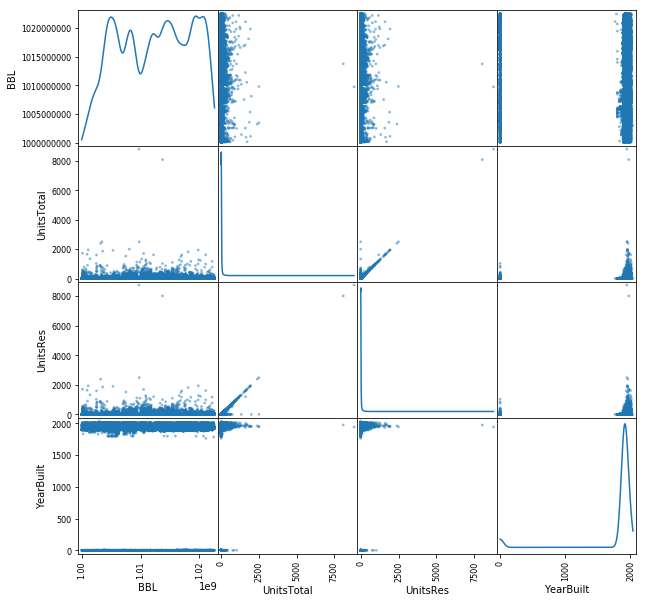

In [11]:
#leave (dont try this scatter matrix before cleaning the data, it will take a while)
sfig = pd.scatter_matrix(bsize, s=30, figsize=(10, 10), diagonal='kde')

### Figure 2: Scatter matrix of all the numerical values in the MNPluto_16v2.csv dataset. We can already observed some interesting linear and non-linear correlations between the variables. However, I believe after further data cleaning, we will be able to obtain a more clean picture.

## converting  the relevant columns to numeric values and throwing away spurious entries

use pd.to_numeric() to convert strings to numeric values, remember the keyword "errors" which will be useful


In [12]:
nrg['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(nrg['Reported Property Floor Area (Building(s)) (ft²)'], \
                                                                        errors='coerce').astype(float)

In [13]:
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce').astype(float)

In [14]:
##check that your conversion worked: e.g.
nrg['Site EUI(kBtu/ft2)'].astype(float)[:10], bsize.BBL.astype(float)[:10]

(0   NaN
 1   NaN
 2   NaN
 3   NaN
 4   NaN
 5   NaN
 6   NaN
 7   NaN
 8   NaN
 9   NaN
 Name: Site EUI(kBtu/ft2), dtype: float64, 0    1.000010e+09
 1    1.000090e+09
 2    1.000158e+09
 3    1.000130e+09
 4    1.000010e+09
 5    1.000010e+09
 6    1.000130e+09
 7    1.000090e+09
 8    1.000030e+09
 9    1.000120e+09
 Name: BBL, dtype: float64)

In [15]:
##check that your conversion worked: e.g.
print ("number of missing energy observations:", np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum())

number of missing energy observations: 4623


In [16]:
##check that your conversion worked: e.g.
print ("fraction of missing energy observations: %.2f"%(np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      len(nrg['Site EUI(kBtu/ft2)'])))

fraction of missing energy observations: 0.29


 ## merge the 2 datasets
 I can merge the dataframes on NYC Borough, Block, and Lot: BBL

In [17]:
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919.0
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200.0
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000.0


In [25]:
#leave
#merge in a geodataframe for mapping, and if you want in a regular DF for analysis (more portable)
bblnrgdataGPD = bsize.merge(nrg, on='BBL').dropna()
bblnrgdata = pd.merge(nrg, bsize, on='BBL').dropna().drop(columns=['geometry'])

In [26]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsTotal,UnitsRes,YearBuilt
2,1.013110e+09,125.4,330000.0,56,0,1977
10,1.010140e+09,154.9,841709.0,2,0,1999
15,1.007660e+09,122.3,59468.0,8,0,1912
16,1.008150e+09,117.0,364000.0,24,0,1954
18,1.005050e+09,82.1,235370.0,24,0,1926


# Plot the data as a choropleth for the 2 quantities of interest: number of units and energy consumed energy

In [27]:
bblnrgdataGPD['UnitsTotalLog'] = np.log10(bblnrgdataGPD['UnitsTotal'] + 1)
bblnrgdataGPD['EnergyLog'] = np.log10(bblnrgdataGPD['Site EUI(kBtu/ft2)'] + 1)

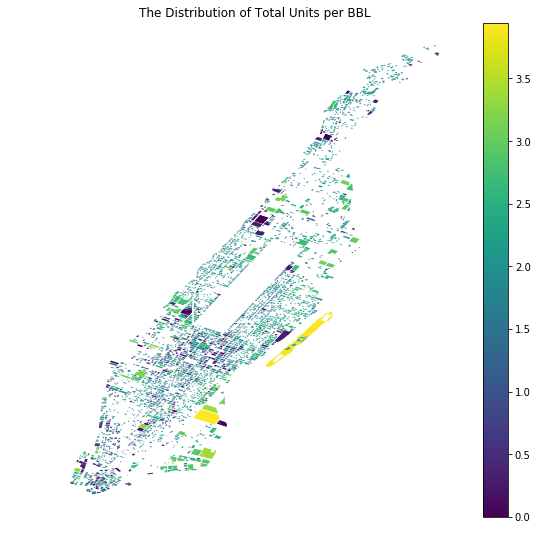

In [78]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(222)
ax.axis('off')
plt.title('The Distribution of Total Units per BBL')
bblnrgdataGPD.plot(column='UnitsTotalLog', ax=ax,legend=True)

### Figure 3: The Distribution of Total Units per BBL. We discover some interesting areas with high volume of energy use of the east side of Manhattan. We can see that more building leads to more energy consumption. As in the two graphs, regions with higher values indicate that they use more energy.

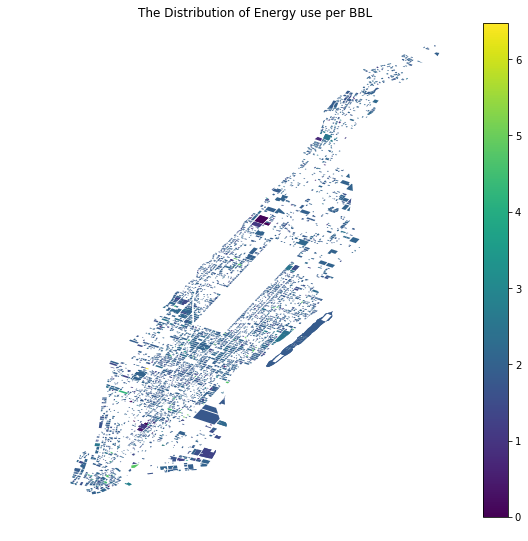

In [79]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(221)
ax.axis('off')
plt.title('The Distribution of Energy use per BBL')
bblnrgdataGPD.plot(column='EnergyLog', ax=ax,legend=True)

### Figure 4: The Distribution of Energy Use per BBL. We can see that more building leads to more energy consumption. As in the two graphs, regions with higher values indicate that they use more energy.

# feature engineering
the question was not if larger buildings consume more energy, its if occupancy increases consumption, so we want to model *total energy* with *total units*.
Create a total energy column from the columns you have.
Plot a column vs the other. You will be unable to see most of the points (as in the plot below). Make another plot "zooming in" to remove some outliers from the view and see if this reveals some patterns.

minimum building energy value 5344.000000
maximum building energy value 67793880000.000000


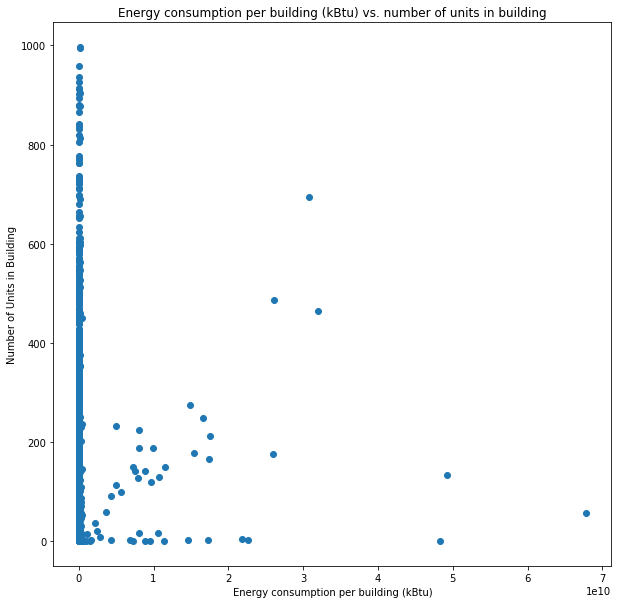

In [28]:
## multiplying area by energy/area to get total energy per building
bblnrgdata['nrg'] = bblnrgdata[\
    'Reported Property Floor Area (Building(s)) (ft²)'].astype(float) *\
                bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)
energy = bblnrgdata[(bblnrgdata['UnitsTotal'] < 1000) & (bblnrgdata['Site EUI(kBtu/ft2)'] < 1500000)]
energy = energy[energy.nrg != 0]
print('minimum building energy value %f' % min(energy.nrg))
print('maximum building energy value %f' % max(energy.nrg))

plt.figure(figsize=(10,10))
plt.title('Energy consumption per building (kBtu) vs. number of units in building')
plt.xlabel('Energy consumption per building (kBtu)')
plt.ylabel('Number of Units in Building')
plt.scatter(energy['nrg'], energy['UnitsTotal'])

### Figure 4: Energy consumption per building (kBtu) vs. number of units in building. We can see that there is roughly a positive linear regression between the two. That is, more energy consumption means more building. And vice versa.

# The magic of log scales!
**Please read the following vcarefully! this is the only opportunity I have to discuss this with you this year. **

Very often in science we will visualize data in log scale and model log data instead of the natural dataset (generally in log10).

In in log10 every order of magnitude is separate by a unit: log10(10) = 1, log10(100) = 2, log10(100000)=5 (basically log10 gives you the number of 0's in its argument, or the *order of magnitude*)





/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0, 0.5, '$log_{10}$(x)')

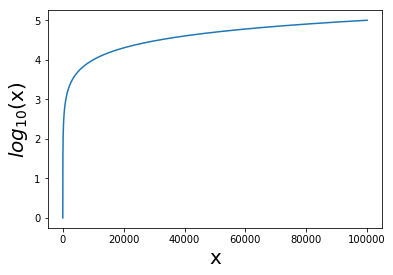

In [92]:
pl.plot(np.arange(100000), np.log10(np.arange(100000)), '-')
pl.xlabel("x", fontsize=20)
pl.ylabel(r"$log_{10}$(x)", fontsize=20)

The logarithm is a monotonic function : wherever its argument grows the function grows, wherever its argument decrease its log decrease. It's a function that grows fast when the argument is small and slowly when the argument is large, so it compresses the scale. 

Another property of the logarithm is that if the relationship between data is a power law (y = x^a) then the relationship between the log of the variables is linear! And we know that modeling things with linear models is easy!

	log_10(x^y) = y ∙ log_10(x)
    
And since power laws are very common in nature we often model with power laws, or with inear relationships in log space.

# Plot both NRG vs Units total and Units total vs NRG, both in log space

Surely there is a right way to think about which one is the independent and the dependent variable in this problem: do we think energy consumption causes occupancy or occupancy causes consumption?

You are going to have to limit the axis values or you will not see anything: 

    energy between (1000,1e10)

    units between (1,1000)

You can cut the axis to visualize the data like this, **but you will need to cut the data to remove datapoint outside of this range when you model to get a good model.**

to visualize the data in log scale you can use the dataframe plotting method with the argument 

    loglog=True


In [93]:
energy.head(3)

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsTotal,UnitsRes,YearBuilt,nrg
2,1.013110e+09,125.4,330000.0,56,0,1977,41382000.0
10,1.010140e+09,154.9,841709.0,2,0,1999,130380724.1
15,1.007660e+09,122.3,59468.0,8,0,1912,7272936.4


In [29]:
energy = bblnrgdata[(bblnrgdata['nrg'] > 1000) & (bblnrgdata['nrg'] < 1e10) & (bblnrgdata['UnitsTotal'] > 1) & (bblnrgdata['UnitsTotal'] < 1000)]

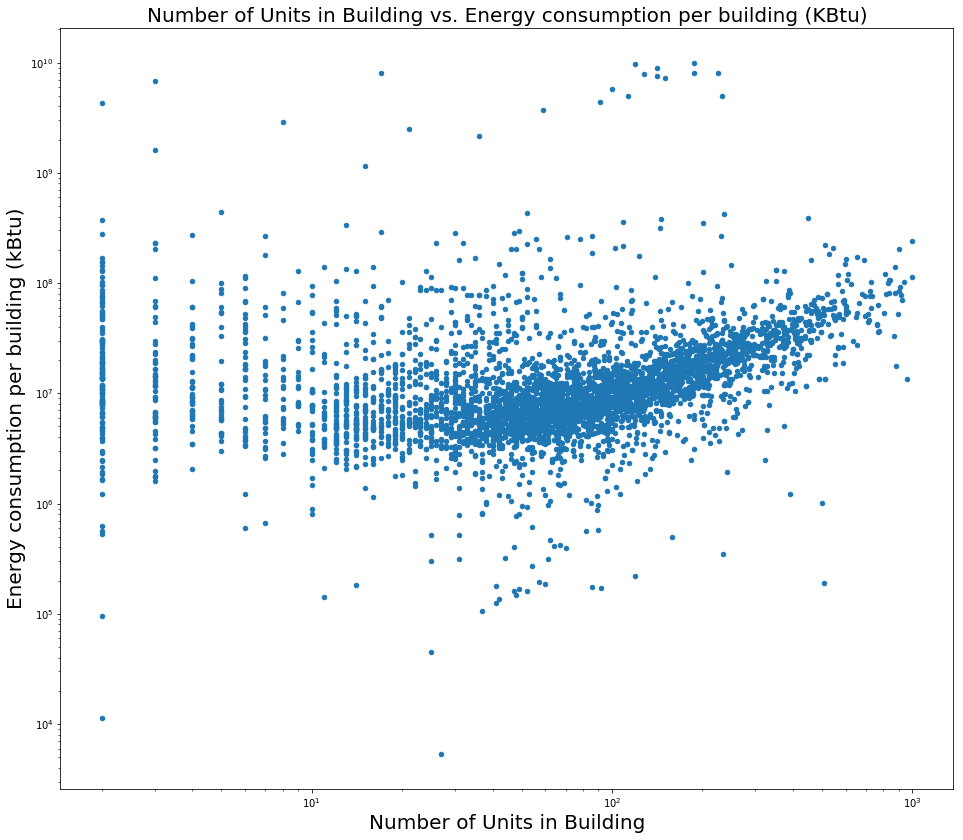

In [182]:
ax = energy.plot(kind='scatter', y='nrg', x='UnitsTotal', 
                   marker='o',  figsize=(16, 14), loglog=True)
plt.title('Number of Units in Building vs. Energy consumption per building (KBtu)', fontsize=20)
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

### Figure 6: Number of Units in Building vs. Energy consumption per building (KBtu)

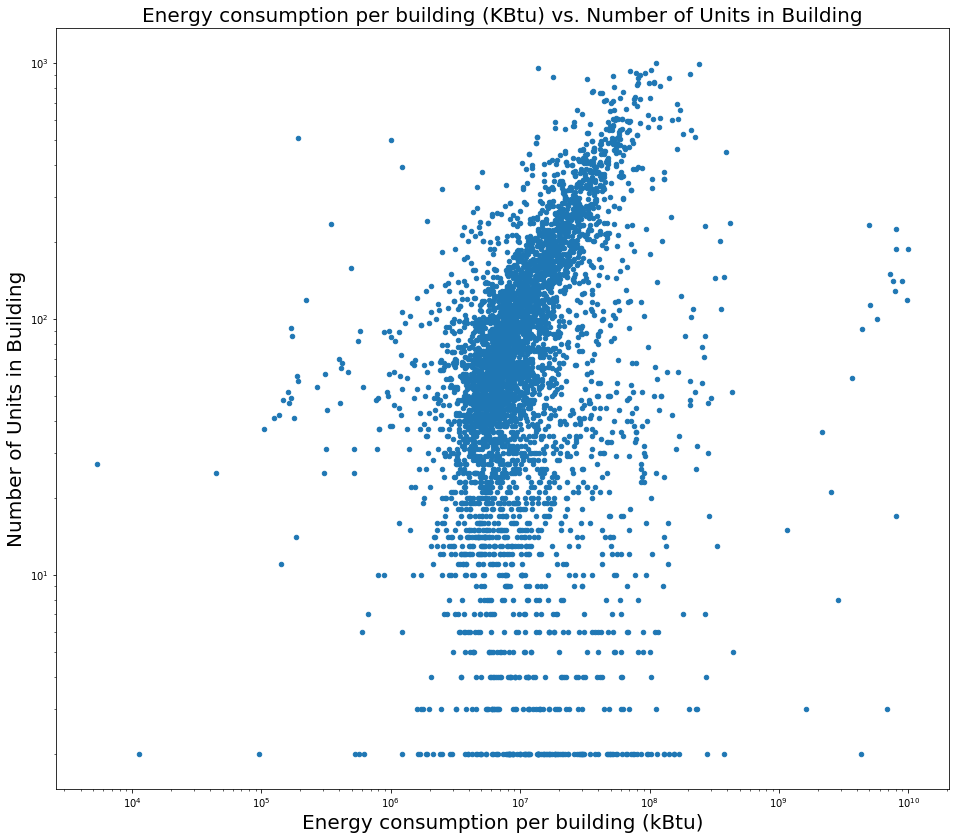

In [183]:
ax = energy.plot(kind='scatter', y='UnitsTotal', x='nrg', 
                   marker='o',  figsize=(16, 14), loglog=True)
plt.title('Energy consumption per building (KBtu) vs. Number of Units in Building', fontsize=20)
xl = ax.set_xlabel("Energy consumption per building (kBtu)", fontsize=20)
yl = ax.set_ylabel("Number of Units in Building", fontsize=20)

### Figure 7: Energy consumption per building (kBtu) vs. Number of Units in Building

# Fit the data with a line in log space:  

**make sure you print the summary and plot the data and the model**

## Model NRG as a linear function of number of units in the building 
Ciertainly there is a right way to think about this: which is the *independent* and the *dependent* variable? which do we think causes which? do units "cause"energy consumption or vice versa? please answer below

### I believe units cause energy. In other words, more units means more energy consumption.

However, indulge me and try both models: models (nrg vs units total & units total vs nrg). 

- create the models with statsmodels
- print the model summary
- plot the data and the fit
- Check and comment on how the following model diagnostics change: 
        R^2 and LogLikelihood
        
(remember to use only the data in the appropriate range, see the previous step)

### Units vs Energy

In [184]:
# take the log of units and energy, prepared it for later usage 
energy['log_units'], energy['log_energy'] = np.log10(energy.UnitsTotal), np.log10(energy.nrg)
log = smf.ols(formula='log_energy ~ log_units',data = energy).fit()
log.summary()

/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_energy   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     260.2
Date:                Sun, 25 Nov 2018   Prob (F-statistic):           5.38e-57
Time:                        13:54:03   Log-Likelihood:                -2836.4
No. Observations:                4610   AIC:                             5677.
Df Residuals:                    4608   BIC:                             5690.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.6684      0.023    285.974      0.000       6.623       6.714
log_units      0.2028      0.013     16.132      0.000       0.178       0.227
==============================================================================
Omnibus:                     1342.840   Durbin-Watson:                   1.583
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13722.745
Skew:                           1.090   Prob(JB):                         0.00
Kurtosis:                      11.166   Cond. No.                         8.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [185]:
energy.head(3)

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsTotal,UnitsRes,YearBuilt,nrg,log_units,log_energy
2,1.013110e+09,125.4,330000.0,56,0,1977,41382000.0,1.748188,7.616811
10,1.010140e+09,154.9,841709.0,2,0,1999,130380724.1,0.301030,8.115213
15,1.007660e+09,122.3,59468.0,8,0,1912,7272936.4,0.903090,6.861710


Text(0.5, 1.0, 'log units vs. log energy')

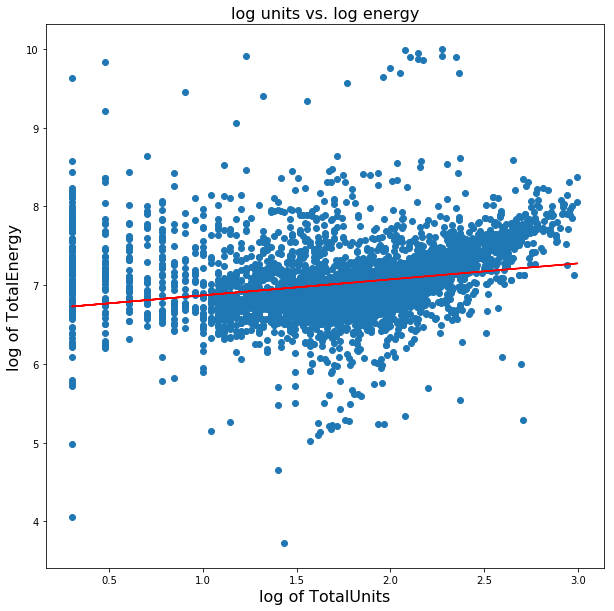

In [186]:
# plot the data and the line 
pl.figure(figsize=[10,10])
pl.scatter(energy['log_units'], energy['log_energy'])
pl.plot(energy['log_units'], log.predict(),'r')
pl.xlabel('log of TotalUnits', fontsize=16)
pl.ylabel('log of TotalEnergy', fontsize=16)
pl.title('log units vs. log energy', fontsize=16)

### Energy against Units

In [187]:
log2 = smf.ols(formula='log_units ~ log_energy',data = energy).fit()
log2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_units   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     260.2
Date:                Sun, 25 Nov 2018   Prob (F-statistic):           5.38e-57
Time:                        13:54:08   Log-Likelihood:                -3441.9
No. Observations:                4610   AIC:                             6888.
Df Residuals:                    4608   BIC:                             6901.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0737      0.115     -0.641      0.522      -0.299       0.152
log_energy     0.2637      0.016     16.132      0.000       0.232       0.296
==============================================================================
Omnibus:                      799.183   Durbin-Watson:                   1.456
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1374.155
Skew:                          -1.126   Prob(JB):                    4.04e-299
Kurtosis:                       4.444   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'log units vs. log energy')

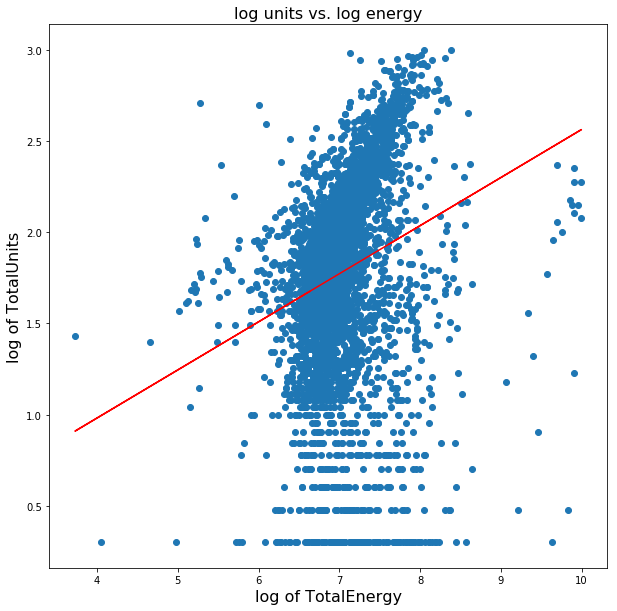

In [188]:
# plot the data and the line 
pl.figure(figsize=[10,10])
pl.scatter(energy['log_energy'], energy['log_units'])
pl.plot(energy['log_energy'], log2.predict(),'r')
pl.ylabel('log of TotalUnits', fontsize=16)
pl.xlabel('log of TotalEnergy', fontsize=16)
pl.title('log units vs. log energy', fontsize=16)

## Comments
### So the R2 remain the same, which is 0.053, for both models. The log likelihood chages from -2836 to -3441. Therefore, the first model better explains the relationship between dependent and independent variable. In other words, "Units cause energy".

# Second degree polynomial fit

model the data with a slightly more complex model: 
    
    y = ax*x + bx + c, 

instead of 
        
    y = bx + c
    
**make sure you print the summary and plot the data and the model**


In [189]:
second = smf.ols(formula='log_energy ~ I(log_units ** 2) + log_units',data = energy).fit()
second.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_energy   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     589.4
Date:                Sun, 25 Nov 2018   Prob (F-statistic):          1.18e-228
Time:                        13:54:12   Log-Likelihood:                -2437.9
No. Observations:                4610   AIC:                             4882.
Df Residuals:                    4607   BIC:                             4901.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.6327      0.039    195.338      0.000       7.556       7.709
I(log_units ** 2)     0.4357      0.015     29.488      0.000       0.407       0.465
log_units            -1.1819      0.048    -24.444      0.000      -1.277      -1.087
==============================================================================
Omnibus:                     1507.906   Durbin-Watson:                   1.682
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27669.826
Skew:                           1.086   Prob(JB):                         0.00
Kurtosis:                      14.804   Cond. No.                         45.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'log units vs. log energy with 2nd degree polynomial fit')

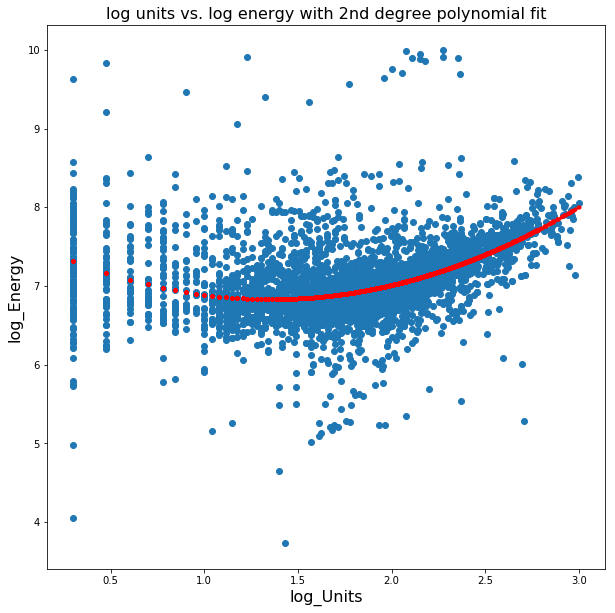

In [190]:
pl.figure(figsize=[10,10])
pl.scatter(energy['log_units'], energy['log_energy'])
pl.plot(energy['log_units'],second.predict(),'r.')
pl.xlabel('log_Units', fontsize=16)
pl.ylabel('log_Energy', fontsize=16)
pl.title('log units vs. log energy with 2nd degree polynomial fit', fontsize=16)

### Figure 8: log units vs. log energy with 2nd degree polynomial fit

# calculate the chi square and likelihood of your model

## Define a chisquare function

In [227]:
#leave
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    errors = np.ones(len(data)) if errors is None else errors
    return float(np.sum(((model - data) ** 2) / (errors ** 2)))
    
    

In [230]:
chi2(energy['log_units'],log2.predict())

1201.5076747068947

## Define and calculate errors

Assume Poisson statistics and calculate the errors accordingly. Remember that you have used 2 quantities combined linearly to calculate the energy (your *dependent* variable) , so the errors combine in quadrature!

    Total Error = sqrt(error1^2 + error2^2)
    
Your *independent* variable has uncertainty also! assume it is also Poissonian

** propagation of errors on the log:**
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [30]:
bblnrgdataCut = energy

In [214]:
bblnrgdataCut['errorsnrg'] = np.sqrt((bblnrgdataCut['Reported Property Floor Area (Building(s)) (ft²)']) ** 2 + \
                (bblnrgdataCut['Site EUI(kBtu/ft2)']) ** 2)
bblnrgdataCut['errorsunits'] = np.sqrt(bblnrgdataCut['UnitsTotal'])
bblnrgdataCut['errors_log_units'] = bblnrgdataCut['errorsunits'] / (bblnrgdataCut['UnitsTotal'] * np.log(10))
bblnrgdataCut['errors_log_nrg'] = bblnrgdataCut['errorsnrg'] / (bblnrgdataCut['nrg'] * np.log(10))

/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [200]:
bblnrgdataCut.head(3)

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsTotal,UnitsRes,YearBuilt,nrg,log_units,log_energy,errorsnrg,errorsunits
2,1.013110e+09,125.4,330000.0,56,0,1977,41382000.0,1.748188,7.616811,330000.023826,7.483315
10,1.010140e+09,154.9,841709.0,2,0,1999,130380724.1,0.301030,8.115213,841709.014253,1.414214
15,1.007660e+09,122.3,59468.0,8,0,1912,7272936.4,0.903090,6.861710,59468.125759,2.828427


## Make 3 plots: one with x errors, one with y errors, one with x and y errors. 

with pylab you can do it with pl.errorbar(x, y, xerr=xerror, yerr=yerror)

The largest error bar is for


,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsTotal,UnitsRes,YearBuilt,nrg,log_units,log_energy,errorsnrg,errorsunits,errors_log_units,errors_log_nrg
4622,1.003620e+09,31.1,5207812.0,461,461,1950,161962953.2,2.663701,8.209416,5.207812e+06,21.470911,0.020227,0.013964


/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/matplotlib/_constrained_layout.py:158: UserWarning: There are no gridspecs with layoutboxes. Possibly did not call parent GridSpec with the figure= keyword
  warnings.warn('There are no gridspecs with layoutboxes. '
/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/matplotlib/_constrained_layout.py:158: UserWarning: There are no gridspecs with layoutboxes. Possibly did not call parent GridSpec with the figure= keyword
  warnings.warn('There are no gridspecs with layoutboxes. '
/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/matplotlib/_constrained_layout.py:158: UserWarning: There are no gridspecs with layoutboxes. Possibly did not call parent GridSpec with the figure= keyword
  warnings.warn('There are no gridspecs with layoutboxes. '


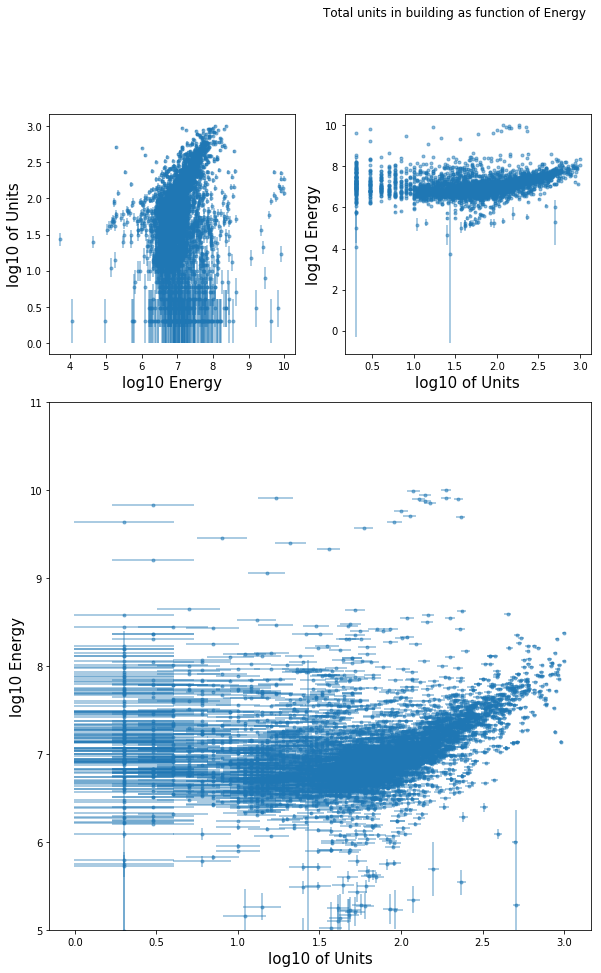

In [215]:
#I could also include errors for number of units
fig2 = plt.figure(constrained_layout=True, figsize=(15,15))

gs1 = gridspec.GridSpec(3, 3, figure=fig2)
gs1.update(left=0.68, right=0.68, wspace=0.2)


ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax1.errorbar(np.log10(bblnrgdataCut.nrg), np.log10(bblnrgdataCut.UnitsTotal), 
            yerr=bblnrgdataCut.errors_log_units, fmt='.',
            alpha=0.5)
ax1.set_ylabel("log10 of Units", fontsize=15)
ax1.set_xlabel("log10 Energy", fontsize=15)
pl.suptitle("Total units in building as function of Energy")


ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
ax2.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
            yerr=bblnrgdataCut.errors_log_nrg, fmt='.',
            alpha=0.5)
ax2.set_xlabel("log10 of Units", fontsize=15)
ax2.set_ylabel("log10 Energy", fontsize=15)

ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax4.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
            yerr=bblnrgdataCut.errors_log_nrg,
           xerr=bblnrgdataCut.errors_log_units, alpha=0.5, fmt='.')
ax4.set_xlabel("log10 of Units", fontsize=15)
ax4.set_ylabel("log10 Energy", fontsize=15)
ax4.set_ylim(5,11)

print ("The largest error bar is for")
bblnrgdataCut[bblnrgdataCut.errorsnrg == bblnrgdataCut.errorsnrg.max()]


Figure 7: The same as Figure 5 and 6, but with errorbars. In the top panel the errors on the Units in the building are plotted, in the bottom panels the errors on the energy are plotted, but they are too small to see,  and both on the right side panel. The bottom right panel is a zoom-in of the bottom left panel. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it. 

IMPORTANT! errors as the square root of the measurement (Poisson statistics) are ONLY meaningful when you are potting dimensionless quantoities! here it is preposterous to assume that the errors are the square root of the measurement. WHY? because then if I express my energy by sq meter, instead of sq feet, I get a different error on the measurement for the same measurement - which makes no sense! However, in this case, I am not using the errors to create the model (no WLS for example) so this error allows me to compare uncertainty on the datapoints. Even if the errors are different, under linear transformations (changes of units for example) the relationship between errors on 2 datapoints will be preserved. 

Notice: No points are taken off if other errors are used, including the sqrt of the log energy, and the correct errors propagation in the log on errors calculated, however, as the sqrt of the tot energy per building, but the errors are in the measured quantities, so this is the proper way to obtain them. In addition the units of energy are extremely large, thus the errors in percentage on the energy are extremely small. These errors are likely to be underestmated due to our ignorance of the details of the experiment.

## Add the errors and calculate the chi square


### calculate the degrees of freedom of this model

In [216]:
# check to see if we have null values
bblnrgdataCut.isnull().sum()

BBL                                                 0
Site EUI(kBtu/ft2)                                  0
Reported Property Floor Area (Building(s)) (ft²)    0
UnitsTotal                                          0
UnitsRes                                            0
YearBuilt                                           0
nrg                                                 0
log_units                                           0
log_energy                                          0
errorsnrg                                           0
errorsunits                                         0
errors_log_units                                    0
errors_log_nrg                                      0
dtype: int64

In [217]:
#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary, but jsut to make sure let's calculate them

# first calculate two values in which we will take the min
total, nrg = len(bblnrgdataCut['UnitsTotal']), len(bblnrgdataCut['nrg']) 
# calcuate degree of freedom 
print('total: ', total, 'nrg: ', nrg)
dof = min(total, nrg) - 2
print ("degrees of freedom:" , dof)

total:  4610 nrg:  4610
degrees of freedom: 4608


In [234]:
print ("Units vs Energy residuals (no errors include): %.2f"%\
       (chi2(bblnrgdataCut.log_units, log.predict()) / 
        float(dof)))

print ("Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       (chi2(bblnrgdataCut.log_units, log.predict(), 
            errors = bblnrgdataCut.errors_log_nrg) / dof))

print ("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(bblnrgdataCut.log_units, log.predict(), 
            errors = np.sqrt(bblnrgdataCut.errors_log_nrg**2 + 
                             bblnrgdataCut.errors_log_units**2))  / dof))


Units vs Energy residuals (no errors include): 27.75
Units vs Energy chi square per DOF w independent variable error only: 1106863011.10
Units vs Energy chi square per DOF : 12982.45


In [235]:
print ("Energy vs Units residuals (no errors include): %.2f"%\
       (chi2(bblnrgdataCut.log_energy, log2.predict()) / dof))

print ("Energy vs Units chi square per DOF w independent variable error only: %.2f"%\
       (chi2(bblnrgdataCut.log_energy, log2.predict(), 
            errors = bblnrgdataCut.errors_log_nrg) / dof))

print ("Energy vs Units chi square per DOF : %.2f"%\
       (chi2(bblnrgdataCut.log_energy, log2.predict(), 
            errors = np.sqrt(bblnrgdataCut.errors_log_nrg**2 + 
                             bblnrgdataCut.errors_log_units**2))  / dof))


Energy vs Units residuals (no errors include): 27.69
Energy vs Units chi square per DOF w independent variable error only: 2123232432.63
Energy vs Units chi square per DOF : 15911.34


### Compare the models using the  chi square:
### We can see that the log1, which is the units vs. energy model, has a in general relatively small chi-square. In other words, a smaller chi-square value means a better model.

If the result of the units vs energy surprises you plot the influence plot for the model. Except the default statsmodels influence plot is a bit of a mess, cause so many points have high leverage, and thus high influence, that the labels cover the span of the plot and make it useless. One could relatively easily engineered one's own influence plot, but instead for the purpose of this discussion comparing the units vs energy with the energy vs units influence plot is sufficient to show how many more points with high **leverage** are in the first plot than in the second - look at the axis range! What is happening is that the distribution of points along the exogenous variable is much better suited to a line fit in the energy vs units plot. You want a large spread in the exogenous variable. In the units vs energy most values of the exogenous variable (energy in this case) are clustered in a small range, while the endogenous variable varies greatly for those points. So the core of the distribution has low predictive power, and the importance of the "outliers" with high and low energy values is enhanced in the fit. 

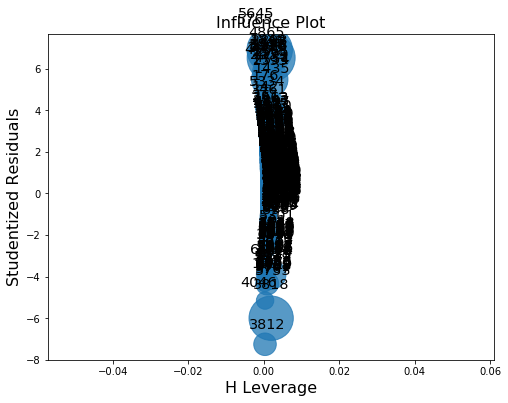

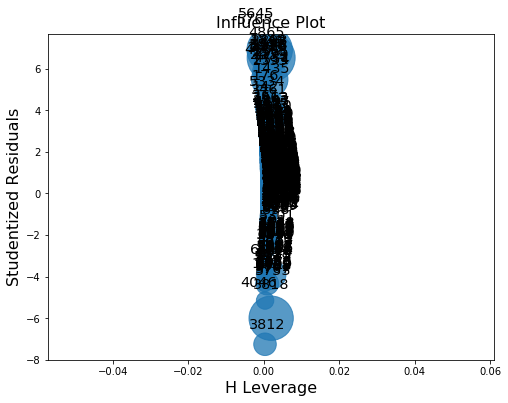

In [249]:
fig, ax = plt.subplots(figsize=(8,6))
statsmodels.graphics.regressionplots.influence_plot(log, ax=ax, criterion="cooks")

### Figure 10: Influence plot of energy vs. units model 

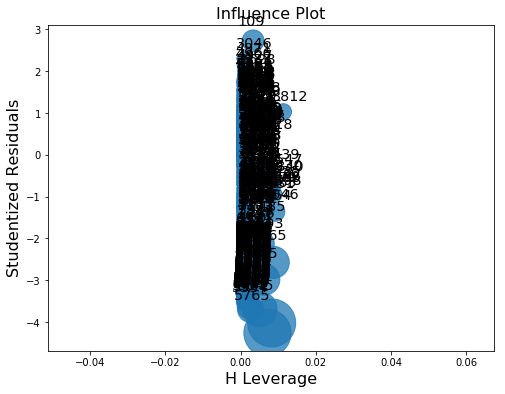

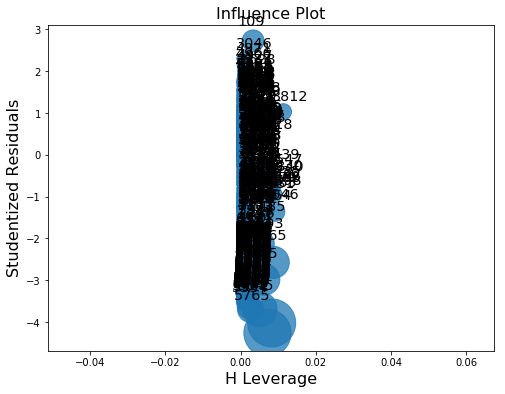

In [245]:
fig, ax = plt.subplots(figsize=(8,6))
statsmodels.graphics.regressionplots.influence_plot(log2, ax=ax, criterion="cooks")

### Figure 11: Influence plot of Units vs. Energy model 

### We can see that clearly there are more points with high leverage at the units vs. energy plot compared to the other model.

# Comparing the linear and curve fit with Likelihood Ratio LR test; we require a significance $\alpha=0.05$

** The curve fit and linear fit od the Energy vs Units can be compared with LR test because they are nested models**

** The difference in the number of degrees of freedom is 1, so the LR statistics will follow a $\chi^2$ distribution with 1 DOF.**


LR = ...
**reject / not reject...**

### H0: Curve fit model does not explain the relationship between x and y better than the linear fit model
### H1: Curve fit model does a better job explaining the relationship between x and y 

In [241]:
second.compare_lr_test(log)

(797.0666744201499, 2.3432593760779218e-175, 1.0)

In [242]:
print("Curve model has a likelihood of %f and that of linear model is %f" % (second.llf, log.llf))

Curve model has a likelihood of -2437.892177 and that of linear model is -2836.425514


### Explanation
### Given the fact that p-value of virtually 0, and 0 < 0.05 and 3.84 < 797, we could reject the null hypothesis so that the curve model fits better than the linear model. Moreover, we can see that curve model has a llf of -2437, which is better compared to that of the linear model, which is -2836. By looking at this, we can also conclude that curve model fits better compared to the original linear model.

# EXTRA CREDIT: a plot of anything related to these data

In [246]:
bblnrgdata.head(3)

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsTotal,UnitsRes,YearBuilt,nrg
2,1.013110e+09,125.4,330000.0,56,0,1977,41382000.0
10,1.010140e+09,154.9,841709.0,2,0,1999,130380724.1
15,1.007660e+09,122.3,59468.0,8,0,1912,7272936.4


Text(0.5, 0, 'Reported floor area')

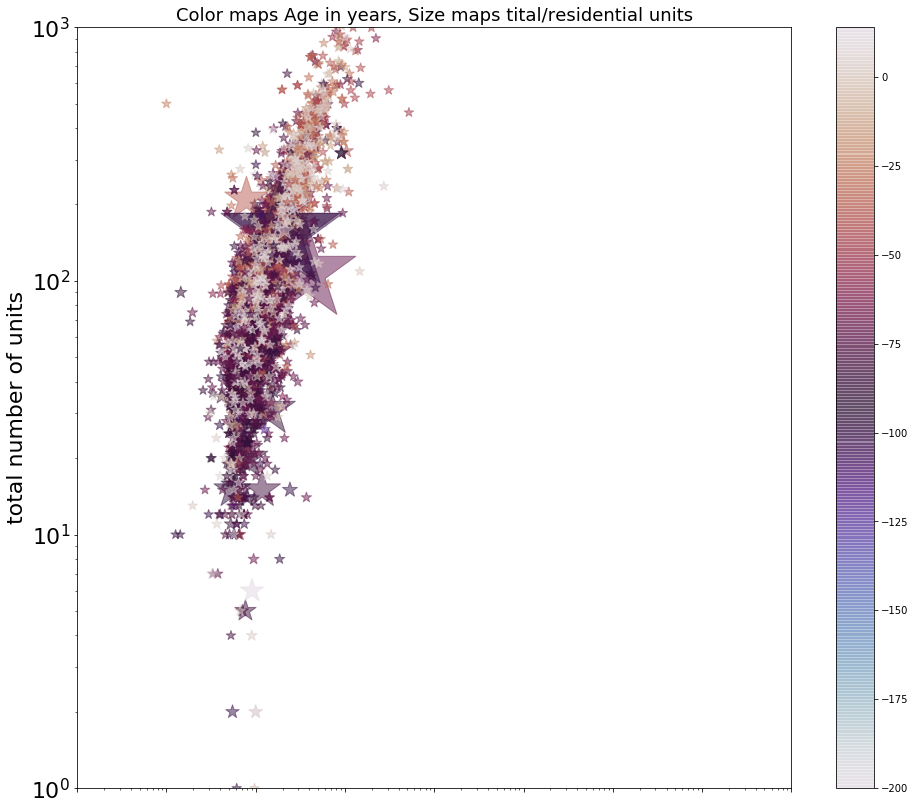

In [35]:

bblnrgdata.plot(kind='scatter',x='Reported Property Floor Area (Building(s)) (ft²)',y='UnitsTotal', 
                fontsize=22, colormap='twilight', alpha = 0.5, 
                marker='*',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), 
                c=bblnrgdata['YearBuilt']-2000, 
                s=bblnrgdata['UnitsTotal']/bblnrgdata['UnitsRes']*100)
pl.title('Color maps Age in years, Size maps tital/residential units', fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("Reported floor area", fontsize=22)

### Figure 12: reported property floor area vs. total units
### There should be a clear positive correlation between the two as more space indicate more units. In this graph, color represents the age (in years) and size is a ratio of tital and residential units.